# Milestone 1 : Artificial Neural Network
**Author: Hafiz Fahrurrozi**

In business, finding new customer is expensive - hence most business will try to keep their loyal customers. Sometimes, customers just cancel their subscription plan without any notification of why. The loss of customer subscription is called churn. We will use a customer dataset from telco (available in [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn/)) to create a model with Artificial Neural Network algorithm for churn prediction.

Features of the dataset:
 - Demography (age, gender, marital, dependents)
 - Charges (monthly, total)
 - Services subscribed (telephone, internet, complementary services)

Target:
 - Churn in last month
 
## Import Libraries
First we import the libraries we will use to create the model. Mainly we will use data manipulation (pandas, numpy, sklearn), data visualization (matplotlib, seaborn), and artificial neural network (tensorflow)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import preprocessing, model_selection, feature_selection, compose, pipeline, ensemble
from imblearn import combine, over_sampling, under_sampling
import tensorflow as tf
import keras_tuner as kt

## Data Loading
Importing the data from csv file can be done with pandas. Along with loading, we can also do simple data exploration to determine whether the data can be used as is or in need of cleaning.

In [2]:
raw = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
raw.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


Here we see that most data are categorical, with some numerical columns. Of those, continuous numerical columns are tenure, MonthlyCharges, and TotalCharges. We see that SeniorCitizen is actually a categorical column which value are 1 and 0, thus we need to replace those values to help in data processing and exploration.

First we see the information and statistical summary for categorical and numerical columns.

In [3]:
display(raw.info())
display(raw.describe(include='object').T)
display(raw.describe(exclude='object').T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


None

,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095


,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


Apparently, TotalCharges is an object column. We can see that there are blank (presumably a space) occuring 11 times on describe(), which means we need to convert the column into numeric and fill the null values.

On another note, we can see that customerID column doesn't yield any useful information based on its mode frequency thus we can safely drop them from the dataset.

Our target column is Churn, and based on its mode frequency we can see that the target is imbalanced (5174 vs 1869).

## Data Cleaning
Based on our exploration above, we need to clean several columns:
 - SeniorCitizen -> change into object column (replace 1 and 0 with Yes and No respectively)
 - TotalCharges -> change into numeric column and fill missing values
 - customerID -> delete the column
 
First we can convert the total charges column and check its distribution to choose how to fill the missing values

In [4]:
raw.TotalCharges = pd.to_numeric(raw.TotalCharges, errors='coerce')
print('Null data count :', raw.TotalCharges.isnull().sum())
print(raw.TotalCharges.describe())

Null data count : 11
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


We have 11 null data and a positively skewed distribution, which tells us to fill the missing values with median and reduce the skew with square root.

In [5]:
raw.TotalCharges = np.sqrt(raw.TotalCharges.fillna(value=raw.TotalCharges.median()))
print(raw.TotalCharges.describe())

count    7043.000000
mean       40.995501
std        24.522872
min         4.335897
25%        20.055547
50%        37.382817
75%        61.535352
max        93.192274
Name: TotalCharges, dtype: float64


The column has been converted to numeric and its skewness reduced.

Next we convert the senior citizen column into object column and remove customer id column to have a clean dataset

In [6]:
raw.SeniorCitizen = raw.SeniorCitizen.replace({1:'Yes',0:'No'})
cln = raw.drop('customerID',axis=1)

## Data Exploration
Using data exploration, we can infer several points about the features that contributes to churn. We can obtain insights by separating the data based on churn and see the data distribution.

First we see the distribution on numerical columns:

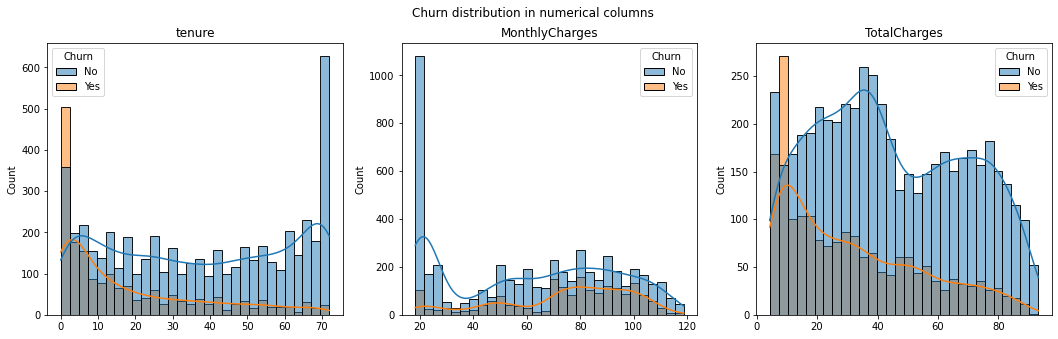

In [7]:
plt.figure(figsize=(18,5))
plt.suptitle('Churn distribution in numerical columns')
for i,j in zip(cln[['tenure','MonthlyCharges','TotalCharges']], range(1,4)):
    plt.subplot(1,3,j)
    plt.title(i)
    sn.histplot(data=cln, x=i, bins=30, kde=True, hue='Churn', color='Blues')
    plt.xlabel('')
plt.show()

Interesting points on numerical columns:
 - New customers are more likely to cancel (based on how long they have stayed with the company and the total charges)
 - Medium-high monthly charges (charges around ~70 - 100) users are more likely to cancel.

To get further insight, we will see the churn distribution on categorical columns

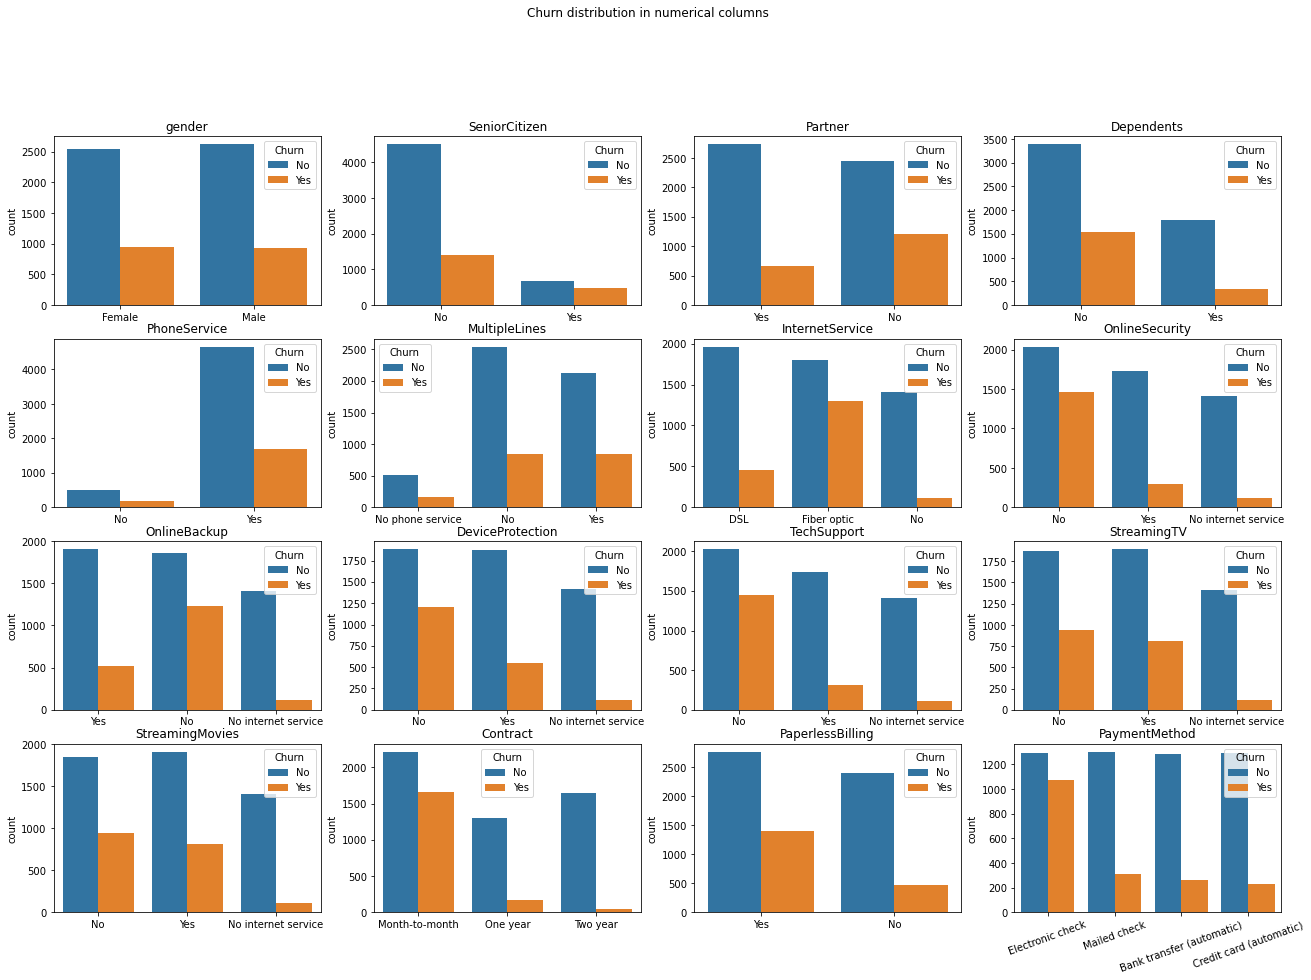

In [8]:
plt.figure(figsize=(22,18))
plt.suptitle('Churn distribution in numerical columns')
for i,j in zip(cln.select_dtypes('object').columns, range(1,17)):
    plt.subplot(5,4,j)
    plt.title(i)
    sn.countplot(data=cln, x=i, hue='Churn')
    plt.xlabel('')
    if j == 16:
        plt.xticks(rotation=20)
plt.show()

Interesting points on categorical columns:
 - Senior citizens are cancelling their plans.
 - Non-married and no dependent users cancel more than their counterpart. It tells us that if multiple people uses the service it would be kept rather than with single peoples.
 - We see that users of multiple telephone line is slightly higher in percentage of churn, although the number is nearly the same with users of single line.
 - In internet category we see that fiber optics users cancel more than DSL users.
 - Consumers without full internet package tend to cancel their plan.
 - Monthly contracts are prone to cancellation.
 - Paperless billing users cancel more than their counterpart.
 
The customer behavior on choosing contract is also interesting with most opting to use monthly plans. Did longer contract translates to longer stay with the company?

<AxesSubplot:xlabel='tenure', ylabel='Contract'>

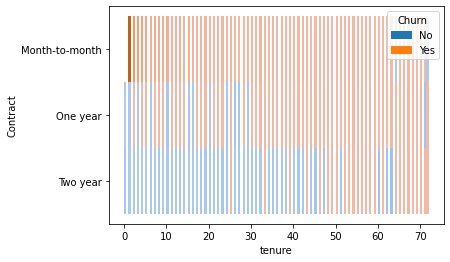

In [9]:
sn.histplot(data=cln, x='tenure', y='Contract', hue='Churn', bins=144)

Long tenure customers are using two year and one year contract more than monthly contract. New users (<6 months tenure) which uses monthly contracts cancel their plan on their 2nd month, most likely subscribing only for trial.

Key takeaway from EDA:
 - New customers (seen by shorter tenure and lower total charges) are more likely to cancel their plan. There might be a problem with the subscription plan: either it doesn't benefit them or there exists a more lucrative offers for them from the competitor. The company might need to review or change their offered plan to ensure their new customers didn't go away.
 - Approximately 50% of the customer are using monthly contracts and a large proportion of them cancelled their plan. Those with longer contracts tend to stay but those who have subscribed for a long duration with long contracts are also prone to churn.
 - Customer with multiple users are more likely to stay, including married and those with dependents.

## Data Preprocessing
Next we need to preprocess our data before the model can use them to predict. In our case, we apply standard scaler to numeric data and one hot encoding to categorical data, then we use feature selection to eliminate less important features. We also apply resampling technique to the training set to help the model learn about the data.

In [10]:
# Split features from target
x = cln.drop('Churn', axis=1)
y = cln.Churn

# Split into train-validation-test
xt,xg,yt,yg = model_selection.train_test_split(x, y, test_size=0.1, stratify=y, random_state=52)
xt,xv,yt,yv = model_selection.train_test_split(xt, yt, test_size=(2/7), stratify=yt, random_state=52)

# Encode the target
lb = preprocessing.LabelBinarizer()
ytt = lb.fit_transform(yt).ravel()
yvt = lb.transform(yv).ravel()
ygt = lb.transform(yg).ravel()

# Feature transformation pipeline
nfeat = ['tenure','MonthlyCharges','TotalCharges']
ntran = preprocessing.StandardScaler()
cfeat = x.select_dtypes('object').columns
ctran = preprocessing.OneHotEncoder(sparse=False)
enc = compose.ColumnTransformer([('nt',ntran,nfeat),('ct',ctran,cfeat)], n_jobs=6)
pt = pipeline.Pipeline([('tr', enc),('fs', feature_selection.RFE(estimator=ensemble.RandomForestClassifier(), n_features_to_select=15))])

# Transform the features
xtt = pt.fit_transform(xt,ytt)
xvt = pt.transform(xv)
xgt = pt.transform(xg)

# Resampling for training
xto, yto = combine.SMOTETomek(random_state=52,n_jobs=52).fit_resample(xtt,ytt)

## Model Definition
Here we create a simple Artificial Neural Network using Sequential sub-module on TensorFlow. Here we use dropout layer and kernel regularizer to keep the model from overfitting the training set.

The model is compiled with binary crossentropy as loss and accuracy as the metrics since this is a clssification problem. For the optimizer, we choose adam since it requires less memory and efficient at processing a lot of parameters.

In [11]:
tf.keras.backend.clear_session()
def build_model(hp):
    mod = tf.keras.Sequential()
    mod.add(tf.keras.layers.Dense(hp.Choice('units_h1', [15, 30, 45, 90, 180, 360]), activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    mod.add(tf.keras.layers.Dropout(hp.Choice('d1',[0.2, 0.4, 0.5])))
    mod.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    mod.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), loss='binary_crossentropy', metrics=['accuracy'],)
    return mod

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50,
    seed=52,
    project_name=None,
    overwrite=True)

tuner.search(xto, yto, epochs=15, validation_data=(xvt, yvt))

Trial 50 Complete [00h 00m 17s]
val_loss: 0.47921621799468994

Best val_loss So Far: 0.4407476484775543
Total elapsed time: 00h 14m 26s
INFO:tensorflow:Oracle triggered exit


In [12]:
tuner.results_summary(3)

Results summary
Results in .\untitled_project
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units_h1: 360
d1: 0.2
learning_rate: 0.01
Score: 0.4407476484775543
Trial summary
Hyperparameters:
units_h1: 30
d1: 0.2
learning_rate: 0.01
Score: 0.4533870816230774
Trial summary
Hyperparameters:
units_h1: 30
d1: 0.2
learning_rate: 0.01
Score: 0.4566005766391754


Based on our hyperparameter tuning, we can use the best hyperparameter and insert it into our model:

In [13]:
mod1, mod2, mod3 = tuner.get_best_models(3)

## Model Training
After defining the model, we train the model on the training set with evaluation on validation set. Here we use 250 training epochs to let the model learn the weights on each neuron.

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)

In [15]:
%%time
his1 = mod1.fit(xto, yto, epochs=150, verbose=0, validation_data=(xvt, yvt), callbacks=[es])

Epoch 00013: early stopping
Wall time: 11.9 s


In [16]:
%%time
his2 = mod2.fit(xto, yto, epochs=150, verbose=0, validation_data=(xvt, yvt), callbacks=[es])

Epoch 00013: early stopping
Wall time: 11.7 s


In [17]:
%%time
his3 = mod3.fit(xto, yto, epochs=150, verbose=0, validation_data=(xvt, yvt), callbacks=[es])

Epoch 00016: early stopping
Wall time: 14.5 s


## Model Evaluation
We can visualize the training result with a simple plot consisting of accuracy and loss to help evaluating the model.

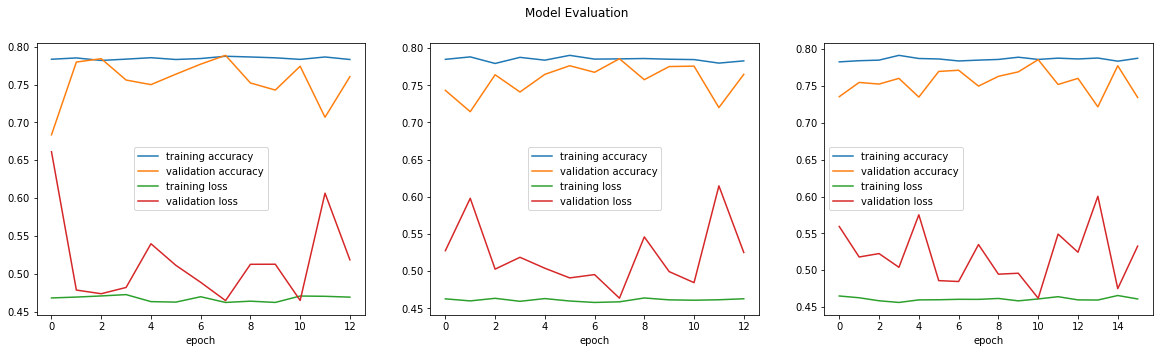

In [18]:
plt.figure(figsize=(20,5))
plt.suptitle('Model Evaluation')
for i, j in zip([his1,his2,his3],[1,2,3]):
    plt.subplot(1,3,j)
    plt.plot(i.history['accuracy'], label='training accuracy')
    plt.plot(i.history['val_accuracy'], label='validation accuracy')
    plt.plot(i.history['loss'], label='training loss')
    plt.plot(i.history['val_loss'], label='validation loss')
    plt.xlabel('epoch')
    plt.legend(loc='best')
plt.show()

## Model Saving
Sadly, the best model changes everytime the models are trained. In this run, the second model is the best one based on its validation accuracy. Saving the best model into an H5 file to port the trained weights helps.

In [19]:
mod2.save('ann-p2m1.h5')

## Model Inference
We will test the model on our test data to see prediction result, and then we will input a whole new data for the model to predict.

In [20]:
m = tf.keras.metrics.Accuracy()
ygp = mod2.predict(xgt).ravel()
ygp[ygp<0.5] = 0
ygp[ygp>=0.5] = 1
m.update_state(ygt, ygp)
print(m.result().numpy())

0.77730495


We got 77% accuracy on the test set, meaning that our model have 75% probability to correctly predict the class of a completely new data. Next we will see what features are needed by our model to predict the class:

In [21]:
feat = np.array(['tenure','MonthlyCharges','TotalCharges'])
feat = np.append(feat, pt.named_steps.tr.named_transformers_.ct.get_feature_names())
print(pt.named_steps.tr.transformers_)
print(feat[pt.named_steps.fs.support_])

[('nt', StandardScaler(), ['tenure', 'MonthlyCharges', 'TotalCharges']), ('ct', OneHotEncoder(sparse=False), Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))]
['tenure' 'MonthlyCharges' 'TotalCharges' 'x0_Male' 'x1_Yes' 'x2_Yes'
 'x5_No' 'x6_Fiber optic' 'x7_No' 'x8_No' 'x9_No' 'x10_No'
 'x13_Month-to-month' 'x14_Yes' 'x15_Electronic check']


All that gibberish upstairs tells us that the features needed are:
 - tenure
 - monthly charges
 - total charges
 - gender (male)
 - senior citizen (yes)
 - partner (yes)
 - multiple lines (no)
 - internet service (fiber optic) and its online package (4 no)
 - contract (monthly)
 - paperless billing (yes)
 - payment method (electronic check)
 
for a total of 15 features. Next we create two synthetic data to see predict their class, and do similar preprocessing to the numerical data.

In [22]:
an = pt.named_steps.tr.named_transformers_.nt.transform([[2,78,np.sqrt(154)]])
ac = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
bn = pt.named_steps.tr.named_transformers_.nt.transform([[33,52,np.sqrt(1627)]]).ravel()
bc = np.array([[0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]])
a = np.append(an,ac).reshape(1,15)
b = np.append(bn,bc).reshape(1,15)

for n in [a,b]:
    res = mod2.predict(n)
    if res < 0.5:
        print('Staying')
    else:
        print('Churn')

Churn
Staying


We got our synthetic customer result: customer A would probably cancel their plan next month and B would continue with theirs.

## Conclusion
Based on our EDA, we see that new customers are jumping the ship as quick as the second month - either because they're dissatisfied with their subscription or they got better offer. The subscription plan is stable on long-time customer who have multiple users either by marriage or by dependents - not on elderlies though, nearly half of them cancels their plan. Another point of concern is also the contract: monthly contracts means the customer can stop their subscription whenever they want, and that is just a question of ***when***. Nearly 40% of those monthly contracts flake out, and 50% of the customer opts to use monthly contracts, which translates into **a lot** of churn.

Training results of our model shows an accuracy score of ~78%, but the validation accuracy is around ~75%. Applying the model to predict the test set gives us a ~77%, which is not far from both training and validation result. This tells us that the model is sufficiently generalized and would be able to predict 3 out of 4 customers correctly, given a large enough set. When using the model to predict churn, it'd be good to compare the result with the features of importance. This serves as a validation to the result and also becomes a point to improve, mainly in the services included as important features. From model inference we can see the important features in predicting customer churn reliably are internet service and its subscribed online packages (security, backup, device protection, tech support). As customers subscribe to those 4 online packages, the less likely they would churn which implied that there is a need to promote those packages to the customer with better deal.